<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Natural_Language_to_SQL_Query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create an `Agent`(LLM with tools access)
---

2 tools

- get_schema (get the table names, column names and datatypes)
- execute_sql(given the sql query, execute the query on our database)

LLM (I want to get the total sales in last month)

user gives the query -> LLM -> get the schema (tool) -> LLM generates SQL query -> execute sql(tool) -> LLM presents the final output.

In [1]:
pip install -q langchain_openai langgraph langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.4 MB/s eta 0:00:00


In [2]:
import sqlite3

conn = sqlite3.connect("shop.db", check_same_thread = False)

In [3]:
# Create users table
conn.execute('''
CREATE TABLE IF NOT EXISTS users (
    id INTEGER PRIMARY KEY,
    name TEXT,
    email TEXT,
    signup_date DATE
)
''')

# Create orders table
conn.execute('''
CREATE TABLE IF NOT EXISTS orders (
    id INTEGER PRIMARY KEY,
    user_id INTEGER,
    amount REAL,
    status TEXT,
    order_date DATE,
    FOREIGN KEY(user_id) REFERENCES users(id)
)
''')

# Insert users
conn.execute("INSERT INTO users VALUES (1, 'Alice', 'alice@example.com', '2024-01-10')")
conn.execute("INSERT INTO users VALUES (2, 'Bob', 'bob@example.com', '2024-03-15')")
conn.execute("INSERT INTO users VALUES (3, 'Charlie', 'charlie@example.com', '2024-03-22')")
conn.execute("INSERT INTO users VALUES (4, 'Diana', 'diana@example.com', '2024-04-05')")
conn.execute("INSERT INTO users VALUES (5, 'Eve', 'eve@example.com', '2024-04-25')")
conn.execute("INSERT INTO users VALUES (6, 'Frank', 'frank@example.com', '2024-05-15')")
conn.execute("INSERT INTO users VALUES (7, 'Grace', 'grace@example.com', '2024-05-18')")
conn.execute("INSERT INTO users VALUES (8, 'Henry', 'henry@example.com', '2024-05-20')")
conn.execute("INSERT INTO users VALUES (9, 'Ivy', 'ivy@example.com', '2024-06-01')")
conn.execute("INSERT INTO users VALUES (10, 'Jack', 'jack@example.com', '2024-06-05')")
conn.execute("INSERT INTO users VALUES (11, 'Kiran', 'kiran@example.com', '2024-06-03')")
conn.execute("INSERT INTO users VALUES (12, 'Lata', 'lata@example.com', '2024-06-04')")
conn.execute("INSERT INTO users VALUES (13, 'Manoj', 'manoj@example.com', '2024-06-06')")

# Insert orders
conn.execute("INSERT INTO orders VALUES (1, 1, 250.00, 'completed', '2024-03-10')")
conn.execute("INSERT INTO orders VALUES (2, 2, 100.00, 'pending', '2024-03-16')")
conn.execute("INSERT INTO orders VALUES (3, 3, 320.00, 'completed', '2024-03-24')")
conn.execute("INSERT INTO orders VALUES (4, 4, 180.00, 'completed', '2024-05-01')")
conn.execute("INSERT INTO orders VALUES (5, 5, 210.00, 'completed', '2024-05-02')")
conn.execute("INSERT INTO orders VALUES (6, 1, 180.00, 'completed', '2024-03-18')")
conn.execute("INSERT INTO orders VALUES (7, 2, 120.00, 'completed', '2024-03-20')")
conn.execute("INSERT INTO orders VALUES (8, 1, 300.00, 'completed', '2024-04-01')")
conn.execute("INSERT INTO orders VALUES (9, 3, 80.00, 'cancelled', '2024-04-10')")
conn.execute("INSERT INTO orders VALUES (10, 4, 250.00, 'pending', '2024-05-05')")
conn.execute("INSERT INTO orders VALUES (11, 6, 400.00, 'completed', '2024-05-20')")
conn.execute("INSERT INTO orders VALUES (12, 7, 320.00, 'completed', '2024-05-22')")
conn.execute("INSERT INTO orders VALUES (13, 8, 150.00, 'pending', '2024-05-25')")
conn.execute("INSERT INTO orders VALUES (14, 9, 220.00, 'completed', '2024-06-02')")
conn.execute("INSERT INTO orders VALUES (15, 10, 500.00, 'completed', '2024-06-06')")

In [4]:
conn.commit()

In [5]:
rows = conn.execute(f"PRAGMA table_info(orders)").fetchall()
cols = "".join([f"{i[0], i[1]}" for i in rows])
cols

"(0, 'id')(1, 'user_id')(2, 'amount')(3, 'status')(4, 'order_date')"

In [6]:
from langchain.agents import tool

@tool
def get_schema() -> str:
  """Return table schemas from the SQLite database"""
  schema = ""
  for table in ["users","orders"]:
    rows = conn.execute(f"PRAGMA table_info({table})").fetchall()
    cols = ",".join([f"{r[1]} {r[2]}" for r in rows])
    schema = schema + f"{table}({cols})\n"
  return schema.strip()

@tool
def execute_sql(query:str)->str:
  """Execute SQL query on the database and return the result"""
  try:
    result = conn.execute(query).fetchall()
    return str(result)
  except Exception as e:
    return f"Error: {str(e)}"


In [7]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict
from langgraph.prebuilt import tools_condition
from langchain.schema import AIMessage
import os

#Add your OPEN AI KEY
os.environ["OPENAI_API_KEY"] = ""
llm = ChatOpenAI(model = "gpt-4o-mini", temperature=0)

import os
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
#Add your LANGCHAIN KEY
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["LANGCHAIN_PROJECT"]="RAG_ADVANCED"

from langsmith import utils
utils.tracing_is_enabled()

True

In [8]:
#Bind the tools to LLM
tools = [get_schema, execute_sql]
llm_with_tools = llm.bind_tools(tools)


class AgentState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

#node
def agent(state: AgentState)->AgentState:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [9]:
builder = StateGraph(AgentState)
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("agent")
builder.add_conditional_edges("agent", tools_condition)
builder.add_edge("tools", "agent")

app = builder.compile()

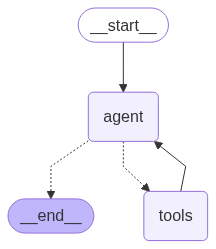

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
input = {"messages": [{"role":"user", "content":"how many users didnt make any purchase, list down the user ids"}]}
result = app.invoke(input)

print(result['messages'])

[HumanMessage(content='how many users didnt make any purchase, list down the user ids', additional_kwargs={}, response_metadata={}, id='d161760e-3a85-43b7-a5dd-36b3ec2a3ca3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2fIDNmfs6Kn8E9qjT1s4bsSS', 'function': {'arguments': '{}', 'name': 'get_schema'}, 'type': 'function'}, {'id': 'call_WoXwYuN1bKlVaOa5RcqvaI2K', 'function': {'arguments': '{"query": "SELECT user_id FROM users WHERE user_id NOT IN (SELECT DISTINCT user_id FROM purchases);"}', 'name': 'execute_sql'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 77, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BixqB7AxbFnpvg

In [12]:
print(result['messages'][-1].content)

There are 3 users who didn't make any purchases. Their user IDs are:

- 11
- 12
- 13


In [13]:
input = {"messages": [{"role":"user", "content":"whats the average amount of sales value for each user"}]}


for output in app.stream(input):
  for key, value in output.items():
    print(f"\n Node '{key}':")
    print(value["messages"])
    print("\n\n",value['messages'][-1].content)


 Node 'agent':
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aq1oFWn39FoRj8HK61z2AtNO', 'function': {'arguments': '{"query":"SELECT user_id, AVG(sales_value) AS average_sales_value FROM sales GROUP BY user_id;"}', 'name': 'execute_sql'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 75, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BixuYWMOM8BDkK4pHdKdIM7cCzcU8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7fab2ee3-3c4e-4948-bd45-a3431c1fc872-0', tool_calls=[{'name': 'execute_sql', 'args': {'query': 'SELECT user_id, AVG(sales_value) AS average_sales_value FROM sales GROUP BY user

##################

Tracked using LANGCHAIN (https://smith.langchain.com/)


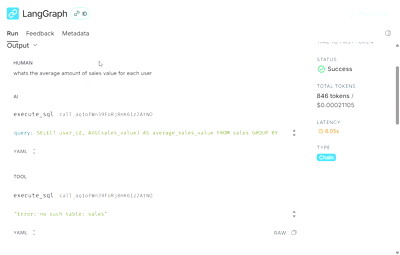